<a href="https://colab.research.google.com/github/sandeepaamcp/privacy-metrics/blob/main/D3_3_User_diversity_metrics_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Observing user diversity metrics in Federated Learning (FL)

To visualise user diversity in FL, directly the diversity among data cannot be used, since data resides private in client devices. Instead, we use model diversity to analyse how diverse the users are. For this, t-SNE based clustering can be used to visualise how the model similarity among clients are varying over the FL full rounds. Moreover, cosine similarity, L1, and L2 distances among the test predictions can also reveal the differences among users.

From the results, it can be observed that the user diversity is high in the initial rounds, meanhwile it tend to decrease with increasing FL rounds.

This code is implemented using Flower FL framework for three datasets, MNIST, CIFAR-10, and NSL-KDD. First, 10 clients were simulated for 10 rounds. Next, the test predictions for each clients at each round is taken. These results were compared using t-SNE, cosine similarity, L1 and L2 distance metrics.

This notebook is run on Google Colab environment. Source to NSL-KDD data is available at `bit.ly/46jexfU`

## Installing libraries

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install opacus --quiet

In [3]:
!pip install adversarial-robustness-toolbox --quiet

In [4]:
!pip install -q flwr[simulation] torchvision

In [5]:
from collections import OrderedDict
from typing import List, Tuple

from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from torch.utils.data import Subset

from tqdm import tqdm

from opacus import PrivacyEngine

from sklearn.model_selection import train_test_split

from itertools import chain

import csv

from keras.losses import cosine_similarity

# from sklearn.metrics import roc_curve, auc
from scipy.optimize import curve_fit

import flwr as fl
from flwr.common import Metrics
import random

import statistics

import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


## Dataset and model configurations

In [6]:
SELECTED_DATASET = 'MNIST' # CAN USE MNIST, CIFAR-10, or NSL-KDD

In [7]:
NUM_CLIENTS = 10 # setting up the number of virtual client devices

In [8]:
BATCH_SIZE = 32 # batch size for the data loaders

## Dataset loader implementation

In [9]:
def get_classes():
  CLASSES_MNIST = ('1','2','3','4','5','6','7','8','9','0')
  CLASSES_CIFAR10 = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
  CLASSES_NSL_KDD_ALL = ('0','1','2','3','4')
  CLASSES_NSL_KDD = (0,1) # ONLY SELECT DOS ATTACKS AND NORMAL TRAFFIC
  if SELECTED_DATASET =='MNIST':
    return CLASSES_MNIST
  elif SELECTED_DATASET =='CIFAR-10':
    return CLASSES_CIFAR10
  elif SELECTED_DATASET == 'NSL-KDD':
    return CLASSES_NSL_KDD
  elif SELECTED_DATASET == 'NSL-KDD-ALL':
    return CLASSES_NSL_KDD_ALL
  else:
    raise ValueError("Invalid dataset name")

In [10]:
# Helper function to generate NSL-KDD dataset.
# The normalized and categorized sample of training data csv is provided separately and can be found in link bit.ly/46jexfU.
# Path to dataset should be adjusted

def generate_nsl_kdd_dataset(train_examples=100000, test_examples=10000, is_only_dos=True):
  file_path_full_training_set = '/content/drive/MyDrive/NSL-KDD/generated/normalized_and_categorized_training_data.csv'

  columns = (['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
      'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
      'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
      'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level', 'protocol_type_cat', 'service_cat', 'flag_cat', 'attack_map'])

  df = pd.read_csv(file_path_full_training_set, header=None, names = columns)
  if is_only_dos:
    df2 = df.loc[df.iloc[:,-1]<2]
  else:
    df2 = df.copy()
  # randomize dataset
  df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

  y = df2.iloc[:,-1:].values.flatten()
  vals, count = np.unique(y, return_counts = True)
  print(vals)
  num_classes = len(vals)
  df2.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
  x = df2.values
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
  x_train = x_train[:train_examples]
  y_train = y_train[:train_examples]
  x_test = x_test[:test_examples]
  y_test = y_test[:test_examples]
  print('Train samples:', len(x_train))
  print('Test samples:', len(x_test))

  # Create a custom dataset class to wrap your data
  class CustomDataset(Dataset):
      def __init__(self, features, labels):
          self.features = torch.tensor(features, dtype=torch.float32)
          self.labels = torch.tensor(labels, dtype=torch.long)

      def __len__(self):
          return len(self.features)

      def __getitem__(self, idx):
          return self.features[idx], self.labels[idx]

  # Create instances of the custom dataset for train and test sets
  train_dataset = CustomDataset(x_train, y_train)
  test_dataset = CustomDataset(x_test, y_test)

  return train_dataset, test_dataset

In [11]:
# iid dataset function
def load_datasets(len_train, len_test):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )

    if SELECTED_DATASET == 'MNIST':
      trainset_all = MNIST("./dataset", train=True, download=True, transform=transform)
      testset_all = MNIST("./dataset", train=False, download=True, transform=transform)
    elif SELECTED_DATASET == 'CIFAR-10':
      trainset_all = CIFAR10("./dataset", train=True, download=True, transform=transform)
      testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)
    elif SELECTED_DATASET == 'NSL-KDD':
      trainset_all, testset_all = generate_nsl_kdd_dataset(is_only_dos=True)
    elif SELECTED_DATASET == 'NSL-KDD-ALL':
      trainset_all, testset_all = generate_nsl_kdd_dataset(is_only_dos=False)
    else:
      raise ValueError("Invalid dataset name")

    subset_train_indices = range(len_train)
    trainset = Subset(trainset_all, subset_train_indices)

    subset_test_indices = range(len_test)
    testset = Subset(testset_all, subset_test_indices)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

In [12]:
# This function is specifically made for non-iid split of dataset.
# We can define multiple strategies for the split.
def non_iid_split(len_train, len_test, iid_split_strategy, label_list, random_ratio, **kwargs):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

  if SELECTED_DATASET == 'MNIST':
    trainset_all = MNIST("./dataset", train=True, download=True, transform=transform)
    testset_all = MNIST("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'CIFAR-10':
    trainset_all = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'NSL-KDD':
    trainset_all, testset_all = generate_nsl_kdd_dataset(is_only_dos=True)

  elif SELECTED_DATASET == 'NSL-KDD-ALL':
    trainset_all, testset_all = generate_nsl_kdd_dataset(is_only_dos=False)

  else:
    raise ValueError("Invalid dataset name")

  subset_test_indices = range(len_test)
  testset = Subset(testset_all, subset_test_indices) # iid testset

  partition_size = int(len_train/NUM_CLIENTS)
  lengths = [partition_size] * NUM_CLIENTS


  datasets = iid_split_strategy(trainset_all, lengths, NUM_CLIENTS, label_list, random_ratio, **kwargs)

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:
      len_val = len(ds) // 10  # 10 % validation set
      len_train = len(ds) - len_val
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
      valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)
  return trainloaders, valloaders, testloader


## This strategy is for having non-iid clients with fixed label for each client, while having a portion of small random labels as well
def iid_split_strategy_fixed_label(dataset, client_dataset_len_list, num_clients, label_list, random_ratio, **kwargs):
  all_subsets = []
  if(len(label_list)<num_clients):
    print('Note: lesser labels for clients than number of requested clients, may consist of same label for multiple clients')

  for i in range(num_clients):
    print('processing client: ', i)
    limit_per_client = client_dataset_len_list[i]
    random_count = int(limit_per_client * random_ratio)

    if(random_count>limit_per_client):
      print('random count is above 100%. Setting 100% randomness.')
      random_count = limit_per_client

    fixed_count = limit_per_client - random_count

    if (len(label_list)<num_clients):
      target_label = label_list[i%len(label_list)] # since num_clients exceed the no. of labels, multiple clients will get the same label
      print('assigning label ',target_label)
      all_indices = [idx for idx, (_, label) in enumerate(dataset) if label == target_label]
      if fixed_count*num_clients>len(all_indices): # check if all possible labels are not sufficient for all shared clients
        fixed_count = len(all_indices)//num_clients
      subset_indices = all_indices[i*fixed_count:(i+1)*fixed_count]

    else:
      target_label = label_list[i]  # Choose the label you want to create a subset for
      all_indices = [idx for idx, (_, label) in enumerate(dataset) if label == target_label]
      if fixed_count*num_clients>len(all_indices): # check if all possible labels are not sufficient for all shared clients
        fixed_count = len(all_indices)//num_clients
      subset_indices = all_indices[:fixed_count]

    random_indices = random.sample(range(1, len(dataset)), random_count)

    subset_indices.extend(random_indices)
    # print(subset_indices)
    random.shuffle(subset_indices)
    subset_dataset = Subset(dataset, subset_indices)
    all_subsets.append(subset_dataset)

  return all_subsets

#### Obtain the data loaders

In [13]:
label_list = get_classes()

In [14]:
trainloaders, valloaders, testloader = non_iid_split(10000, 1000, iid_split_strategy_fixed_label, label_list, 0.1)

processing client:  0
processing client:  1
processing client:  2
processing client:  3
processing client:  4
processing client:  5
processing client:  6
processing client:  7
processing client:  8
processing client:  9


## Define the NN

#### NN related configurations

By setting up DP for NN, we can observe the user diversity metrics change, which can show that the diversity among clients has reduced to a level where clients cannot be distinguished from each other. This can support the idea that DP-based privacy mechanism can provide protection against privacy attacks, which are typically based on observing diversity among users and isolating the target.

In [15]:
class Args:
    epochs=1 # number of local epochs
    max_per_sample_grad_norm=1.5  # clipping norm to guarantee the sensitivity of gradients; necessary to set to non-infinity for DP
    delta=1e-5 # delta in (epsilon, delta)-DP, need to be smaller than 1/sample size
    data_root="./data"
    disable_dp=True
    secure_rng=False
    epsilon=1

args = Args()

In [16]:
class Net_CIFAR10(nn.Module):
    def __init__(self) -> None:
        super(Net_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class Net_NSLKDD(nn.Module):
    def __init__(self):
        super(Net_NSLKDD, self).__init__()
        self.fc1 = nn.Linear(42, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, len(get_classes()))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


class Net_NSLKDD_2(nn.Module):
    def __init__(self):
        super(Net_NSLKDD_2, self).__init__()
        self.fc1 = nn.Linear(42, 512)
        self.relu = nn.ReLU()
        self.middle_layer = nn.Linear(512, 256)  # New middle layer with 256 neurons
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, len(get_classes()))  # Adjust input size to match new middle layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.middle_layer(x)  # Pass through the new middle layer
        x = self.relu(x)  # Apply activation function again
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


class Net_NSLKDD_3(nn.Module):
    def __init__(self):
        super(Net_NSLKDD_3, self).__init__()
        self.fc1 = nn.Linear(42, 512)
        self.additional_layer = nn.Linear(512, 256)  # New additional layer with 256 neurons
        self.middle_layer = nn.Linear(256, 128)  # New middle layer with 128 neurons
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, len(get_classes()))  # Adjust input size to match new middle layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.additional_layer(x)  # Pass through the new additional layer
        x = self.relu(x)  # Apply activation function
        x = self.dropout(x)
        x = self.middle_layer(x)  # Pass through the new middle layer
        x = self.relu(x)  # Apply activation function again
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


#### !! CHANGE THE OUTPUT NN TO TEST DIFFERENT NN ARCHITECTURES FOR NSL-KDD !! ####
def get_nn():
  if SELECTED_DATASET == 'MNIST':
    return Net_MNIST().to(DEVICE)
  elif SELECTED_DATASET == 'CIFAR-10':
    return Net_CIFAR10().to(DEVICE)
  elif SELECTED_DATASET == 'NSL-KDD' or SELECTED_DATASET == 'NSL-KDD-ALL':
    return Net_NSLKDD_3().to(DEVICE)
  else:
    raise ValueError("Invalid dataset name")

In [17]:
def train(net, trainloader, privacy_engine, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

        if not args.disable_dp:
              epsilon = privacy_engine.accountant.get_epsilon(delta=args.delta)
              print(
                  f"(ε = {epsilon:.2f}, δ = {args.delta})"
              )

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def eval(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    real_all = []
    pred_all = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_all.append(labels)
            pred_all.append(predicted)
    loss /= len(testloader.dataset)
    accuracy = correct / total
    real_flat = [int(item) for tensor in real_all for item in tensor.view(-1)]
    pred_flat = [int(item) for tensor in pred_all for item in tensor.view(-1)]
    return loss, accuracy, real_flat, pred_flat

In [18]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

## Implementing a Flower client

In [19]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        privacy_engine = None
        optimizer = torch.optim.Adam(self.net.parameters())
        if not args.disable_dp:
          privacy_engine = PrivacyEngine(secure_mode=args.secure_rng)

          net, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
                module=self.net,
                optimizer=optimizer,
                data_loader=self.trainloader,
                epochs=args.epochs+1,
                target_epsilon=args.epsilon,
                target_delta=args.delta,
                max_grad_norm=args.max_per_sample_grad_norm,
            )
          self.net = net
          # self.optimizer = optimizer
          self.trainloader = trainloader
        train(self.net, self.trainloader, privacy_engine, optimizer, epochs=args.epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [20]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = get_nn()

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [21]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [22]:
# helper function to get pytorch model from model weights
def get_mdl_from_weights(ori_weights):
  model = get_nn()
  weights = [torch.Tensor(weight) for weight in ori_weights]
  model_params = model.state_dict()
  for key, weight in zip(model_params.keys(), weights):
      model_params[key] = weight
  model.load_state_dict(model_params)
  return model

def eval_exp(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    real_all = []
    pred_all = []
    outputs_all = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_all.append(labels)
            pred_all.append(predicted)
            outputs_all.append(outputs.detach().tolist())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    real_flat = [int(item) for tensor in real_all for item in tensor.view(-1)]
    pred_flat = [int(item) for tensor in pred_all for item in tensor.view(-1)]
    outputs_flat = list(chain(*outputs_all))
    return loss, accuracy, real_flat, pred_flat, outputs_flat

def get_pred_from_models(round_no, testloader, target_client_list, client_updates_list):
  updates_list = client_updates_list[round_no]
  all_pred = []
  all_outputs = []
  for ref_cli in target_client_list:
    print('client ID: ',ref_cli)
    ref_mdl_weights = updates_list[ref_cli][0]
    mdl = get_mdl_from_weights(ref_mdl_weights)
    loss, acc, real, pred, per_cli_output = eval_exp(mdl,testloader)
    pred=np.array(pred)
    all_pred.append(pred)
    all_outputs.append(per_cli_output)
  return all_pred, all_outputs

def get_testloader(len_test):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )
  subset_test_indices = range(len_test)

  if SELECTED_DATASET == 'MNIST':
      testset_all = MNIST("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'CIFAR-10':
    testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'NSL-KDD':
    _, testset_all = generate_nsl_kdd_dataset(is_only_dos=True)
  elif SELECTED_DATASET == 'NSL-KDD-ALL':
    _, testset_all = generate_nsl_kdd_dataset(is_only_dos=False)

  else:
    raise ValueError("Invalid dataset name")

  testset = Subset(testset_all, subset_test_indices) # iid testset
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)
  return testloader

### Custom Federated Averaging algorithm
The client parameters can be obtained from the function  ```aggregate_fit()```, which can be used for user diversity analysis. They are obtained by accumulating in ```client_updates_list```, where initial empty is sent to the algorithm during runtime, such that after FL, the client model states can be obtained.



In [23]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.server.strategy import FedAvg

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy

from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.server.strategy.strategy import Strategy

class CustomFedAvg(FedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        client_updates_list = [],
        aggregated_updates_list = [],
        results_all=[],
        global_mdl_list = []
    ) -> None:

        super().__init__()

        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.client_updates_list = client_updates_list
        self.aggregated_updates_list = aggregated_updates_list
        self.results_all = results_all
        self.global_mdl_list = global_mdl_list

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        iter_params_dict = {}
        for item, fit_res in results:
          iter_params_dict[item.cid]= (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)

        self.results_all.append(results)
        self.client_updates_list.append(iter_params_dict)
        aggregated_params_arr = aggregate(weights_results)
        parameters_aggregated = ndarrays_to_parameters(aggregated_params_arr)
        self.aggregated_updates_list.append(aggregated_params_arr)

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [24]:
client_updates_list = []
aggregated_updates_list = []
results = []
global_mdl_list = []
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    client_updates_list = client_updates_list,
    aggregated_updates_list = aggregated_updates_list,
    results_all = results,
    global_mdl_list = global_mdl_list
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1,"scheduling_strategy":'DEFAULT'}

# Start simulation
start_time = time.time()
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    ray_init_args={"log_to_driver": False, "num_cpus": 2, "num_gpus": 0}
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

INFO flwr 2023-09-21 23:18:38,801 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-21 23:18:44,730	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-09-21 23:18:46,718 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7840127387.0, 'object_store_memory': 3920063692.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7840127387.0, 'object_store_memory': 3920063692.0}
INFO flwr 2023-09-21 23:18:46,721 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-21 23:18:46,735 | app.py:224 | Flo

Elapsed time: 95.9198 seconds


## Saving global models


Following code provides saving points for the models

Following models are saved:

1 - save the global model updates for the FL rounds

2 - In each round, save local model updates

At this point, only NN will be supported by Torch for FL in this code


In [25]:
# illustrate sample global model
sample_mdl_9_weights = aggregated_updates_list[9] # getting sample global model at 10th round
mdl = get_mdl_from_weights(sample_mdl_9_weights)
loss, acc, real, pred, per_cli_output = eval_exp(mdl,testloader)
print(f'accuracy:{acc}, loss:{loss}')

accuracy:0.836, loss:0.01948306381702423


In [26]:
# # saving all global models in to files
# for i in range(len(aggregated_updates_list)):
#   mdl_weights = aggregated_updates_list[i] # getting sample global model at 10th round
#   model = get_mdl_from_weights(mdl_weights)
#   torch.save(model.state_dict(), f'/content/drive/MyDrive/SPATIAL/D3.3_work/differential_privacy/global_models/model{i}.pth')

In [27]:
# # Load a sample model
# mdl_load = get_nn()
# mdl_load.load_state_dict(torch.load('/content/drive/MyDrive/SPATIAL/D3.3_work/differential_privacy/global_models/model9.pth'))
# loss, acc, real, pred, per_cli_output = eval_exp(mdl_load,testloader)
# print(f'accuracy:{acc}, loss:{loss}')

### Saving local models

In [28]:
# illustrate sample global model
sample_mdl_9_weights = client_updates_list[9]['1'][0] # getting sample client 1 at 10th round
mdl = get_mdl_from_weights(sample_mdl_9_weights)
loss, acc, real, pred, per_cli_output = eval_exp(mdl,testloader)
print(f'accuracy:{acc}, loss:{loss}')

accuracy:0.743, loss:0.027227496683597564


In [29]:
# all_clients = ['0','1','2','3','4','5','6','7','8','9']
# # saving all global models in to files
# for i in range(len(client_updates_list)):
#   for j in all_clients:
#     mdl_weights = client_updates_list[i][j][0]
#     model = get_mdl_from_weights(mdl_weights)
#     torch.save(model.state_dict(), f'/content/drive/MyDrive/SPATIAL/D3.3_work/differential_privacy/local_models/mdl_round_{i}_client_{j}.pth')

In [30]:
# # Load a sample model
# mdl_load = get_nn()
# mdl_load.load_state_dict(torch.load('/content/drive/MyDrive/SPATIAL/D3.3_work/differential_privacy/local_models/mdl_round_9_client_1.pth'))
# loss, acc, real, pred, per_cli_output = eval_exp(mdl_load,testloader)
# print(f'accuracy:{acc}, loss:{loss}')

## clustering metrics

In [31]:
def eval_exp(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    real_all = []
    pred_all = []
    outputs_all = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_all.append(labels)
            pred_all.append(predicted)
            outputs_all.append(outputs.detach().tolist())
    loss /= len(testloader.dataset)
    accuracy = correct / total
    real_flat = [int(item) for tensor in real_all for item in tensor.view(-1)]
    pred_flat = [int(item) for tensor in pred_all for item in tensor.view(-1)]
    outputs_flat = list(chain(*outputs_all))
    return loss, accuracy, real_flat, pred_flat, outputs_flat

def get_pred_from_models(round_no, testloader, target_client_list, client_updates_list):
  updates_list = client_updates_list[round_no]
  all_pred = []
  all_outputs = []
  for ref_cli in target_client_list:
    print('client ID: ',ref_cli)
    ref_mdl_weights = updates_list[ref_cli][0]
    mdl = get_mdl_from_weights(ref_mdl_weights)
    loss, acc, real, pred, per_cli_output = eval_exp(mdl,testloader)
    pred=np.array(pred)
    all_pred.append(pred)
    all_outputs.append(per_cli_output)
  return all_pred, all_outputs

def get_testloader(len_test):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )
  subset_test_indices = range(len_test)

  if SELECTED_DATASET == 'MNIST':
      testset_all = MNIST("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'CIFAR-10':
    testset_all = CIFAR10("./dataset", train=False, download=True, transform=transform)

  elif SELECTED_DATASET == 'NSL-KDD':
    _, testset_all = generate_nsl_kdd_dataset(is_only_dos=True)
  elif SELECTED_DATASET == 'NSL-KDD-ALL':
    _, testset_all = generate_nsl_kdd_dataset(is_only_dos=False)

  else:
    raise ValueError("Invalid dataset name")

  testset = Subset(testset_all, subset_test_indices) # iid testset
  testloader = DataLoader(testset, batch_size=BATCH_SIZE)
  return testloader

### Round 1

In [32]:
all_clients = ['0','1','2','3','4','5','6','7','8','9']
testloader = get_testloader(len_test=100) # for 100 sample testdata

mdl_pred_round, outputs_raw = get_pred_from_models(round_no=0,testloader=testloader, target_client_list=all_clients, client_updates_list=client_updates_list) # here, we check for the FL round 0

client ID:  0
client ID:  1
client ID:  2
client ID:  3
client ID:  4
client ID:  5
client ID:  6
client ID:  7
client ID:  8
client ID:  9


In [33]:
x_results =  list(chain(*outputs_raw))
n = 100  # Number of repetitions for each element
if SELECTED_DATASET == 'NSL-KDD':
  elements = [0,1,0,1,0,1,0,1,0,1]  # Elements to repeat
elif SELECTED_DATASET == 'MNIST' or SELECTED_DATASET == 'CIFAR-10':
  elements = [0,1,2,3,4,5,6,7,8,9]
y_results = [x for x in elements for _ in range(n)]
x_train = np.array(x_results)
y_train = np.array(y_results)

In [34]:
def draw_tsne(perplexity, n_iter=1000):
  tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=perplexity)
  z = tsne.fit_transform(x_train)
  df = pd.DataFrame()
  df["y"] = y_train
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)
  plt.legend(fontsize=15, loc='lower left')

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.069409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.702770
[t-SNE] KL divergence after 1000 iterations: 0.450921


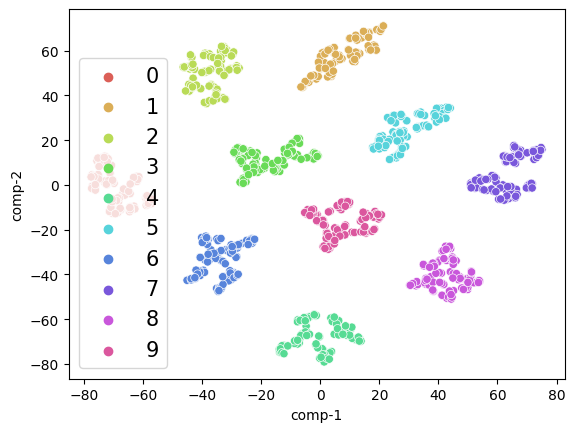

In [35]:
draw_tsne(perplexity=10)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.438211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.169319
[t-SNE] KL divergence after 1000 iterations: 0.018760


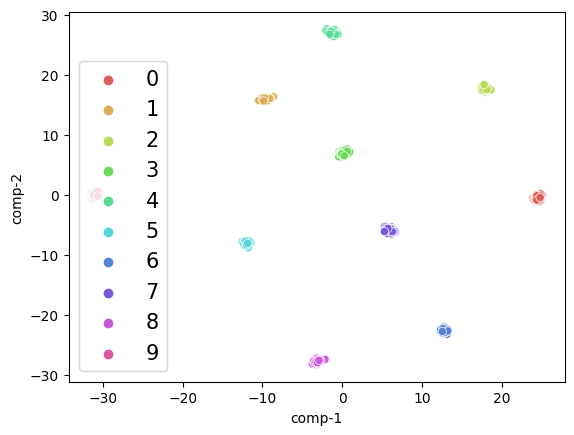

In [36]:
draw_tsne(perplexity=100)

### Round 10

In [37]:
all_clients = ['0','1','2','3','4','5','6','7','8','9']
testloader = get_testloader(len_test=100) # for 100 sample testdata

mdl_pred_round, outputs_raw = get_pred_from_models(round_no=9,testloader=testloader, target_client_list=all_clients, client_updates_list=client_updates_list) # here, we check for the FL round 0

x_results =  list(chain(*outputs_raw))
n = 100  # Number of repetitions for each element
if SELECTED_DATASET == 'NSL-KDD':
  elements = [0,1,0,1,0,1,0,1,0,1]  # Elements to repeat
elif SELECTED_DATASET == 'MNIST':
  elements = [0,1,2,3,4,5,6,7,8,9]

y_results = [x for x in elements for _ in range(n)]
x_train = np.array(x_results)
y_train = np.array(y_results)

client ID:  0
client ID:  1
client ID:  2
client ID:  3
client ID:  4
client ID:  5
client ID:  6
client ID:  7
client ID:  8
client ID:  9


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.277582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.410194
[t-SNE] KL divergence after 1000 iterations: 0.686387


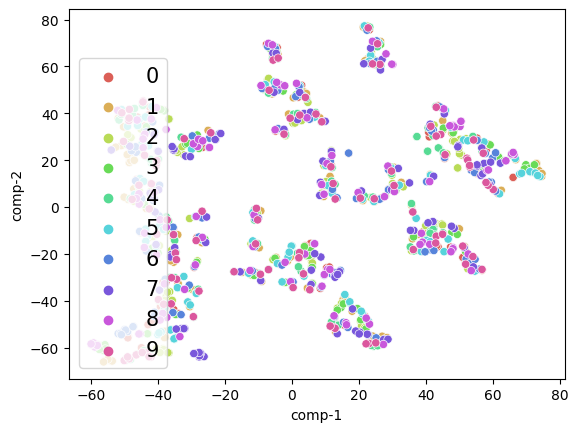

In [38]:
draw_tsne(perplexity=10)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.739167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.261559
[t-SNE] KL divergence after 1000 iterations: 0.356381


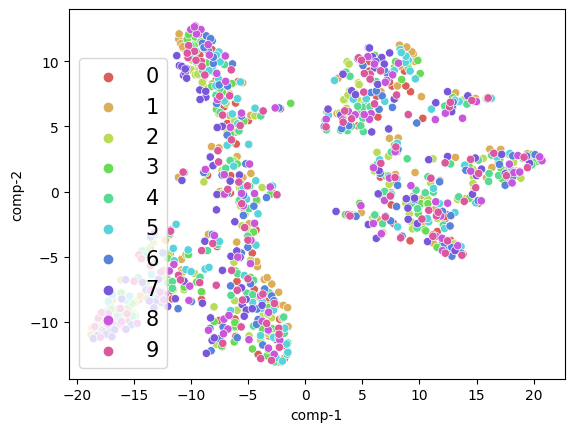

In [39]:
draw_tsne(perplexity=100)

## Other similarity metrics

In [40]:
def calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader):
  loss, acc, real1, pred1 = eval(mdl1,testloader)
  loss, acc, real2, pred2 = eval(mdl2,testloader)
  pred1=np.array(pred1)
  pred2=np.array(pred2)
  MAE = np.mean(np.abs(pred1 - pred2))
  MSE = np.mean((pred1 - pred2)**2)

  vector1 = np.array(pred1, dtype=np.float64)
  vector2 = np.array(pred2, dtype=np.float64)

  # Calculate cosine similarity
  cos_sims = cosine_similarity(vector1, vector2)

  avg_cos_sim = np.mean(cos_sims)

  return MAE, MSE, avg_cos_sim
def get_client_updates_cos_sim(ref_cli, classes, client_updates_list, round_no, testloader):

  updates_list = client_updates_list[round_no]
  cos_sim_all = []
  MAE_all = []
  MSE_all = []
  print('Ref client ID: ', ref_cli)
  print('Round No.: ',round_no)
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in classes:
    print('comparing with class: ', cli)
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]

      mdl1 = get_mdl_from_weights(ref_cli_mdl)
      mdl2 = get_mdl_from_weights(other_mdl)

      MAE, MSE, avg_cos_sim = calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader)
      MAE_all.append(MAE)
      MSE_all.append(MSE)
      cos_sim_all.append(avg_cos_sim)
  return MAE_all, MSE_all, cos_sim_all

### Analysing distance metrics

In [41]:
def calc_l1_l2(mdl1,mdl2):
  weights1 = np.concatenate([arr.flatten() for arr in mdl1])
  weights2 = np.concatenate([arr.flatten() for arr in mdl2])

  L1_distance = np.sum(np.abs(weights1 - weights2))
  L2_distance = np.sqrt(np.sum((weights1 - weights2)**2))

  # print('L1 distance:', L1_distance)
  # print('L2 distance:', L2_distance)
  return L1_distance, L2_distance

In [42]:
def get_client_updates_l2_dist(ref_cli, classes, client_updates_list, round_no):

  updates_list = client_updates_list[round_no]
  l1_all = []
  l2_all = []
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in classes:
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]
      l1, l2 = calc_l1_l2(ref_cli_mdl, other_mdl)
      l1_all.append(l1)
      l2_all.append(l2)
  return l1_all, l2_all

In [43]:
CLASSES_LIST= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
l1_0, l2_0 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=0)
l1_1, l2_1 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=1)
l1_3, l2_3 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=3)
l1_5, l2_5 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=5)
l1_7, l2_7 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=7)
l1_9, l2_9 = get_client_updates_l2_dist(ref_cli='0', classes=CLASSES_LIST, client_updates_list=client_updates_list, round_no=9)

In [44]:
def draw_graph(x_val, y_vals, markers, x_label, y_label, legend=None, markevery=50, loc='upper left', std_vals=None, is_legend=True):
    sns.set_style('whitegrid')
    sns.set_palette('Dark2')

    plt.rcParams['font.size'] = 17
    plt.rcParams['axes.edgecolor'] = 'black'  # Set the edge color to black
    for i in range(len(y_vals)):
        y = y_vals[i]
        plt.plot(x_val, y, linestyle='--', linewidth=2, marker=markers[i], markevery=markevery)

        if std_vals is not None:
            std = std_vals[i]
            err_plus = [y_val + std_val for y_val, std_val in zip(y, std)]
            err_minus = [y_val - std_val for y_val, std_val in zip(y, std)]
            plt.fill_between(x_val, err_plus, err_minus, alpha=0.3)  # Add shaded region for the standard deviation

    plt.ylabel(y_label, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    if legend is not None:
      plt.legend(legend, loc=loc, fontsize=14)
    plt.grid(linestyle='dashed')
    plt.xticks(x_val, x_val)

    plt.tight_layout()
    plt.show()


In [45]:
def save_as_csv(rows,filename):
  with open(filename, 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerows(rows)

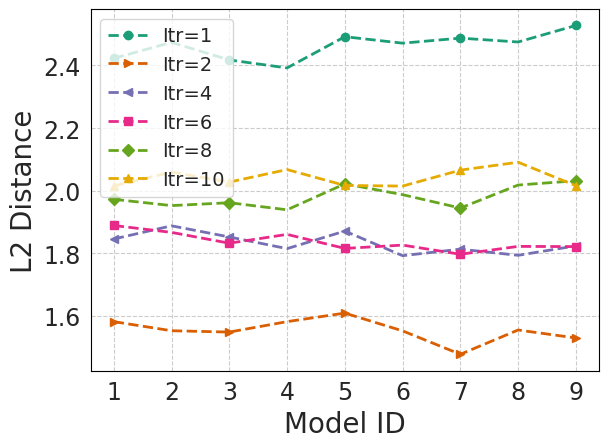

In [46]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[l2_0,l2_1,l2_3,l2_5,l2_7,l2_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='L2 Distance',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'],markevery=2)

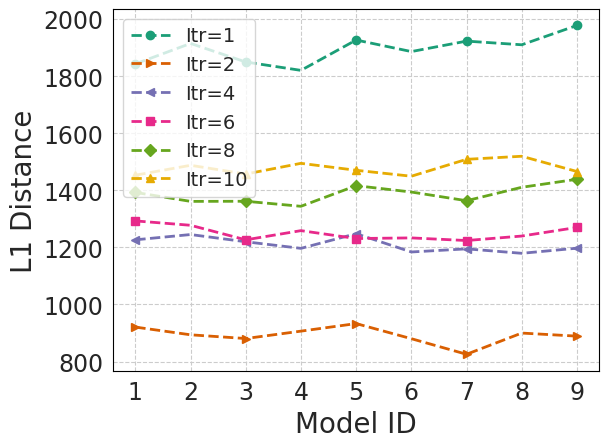

In [47]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[l1_0,l1_1,l1_3,l1_5,l1_7,l1_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='L1 Distance',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'], markevery=2)

In [48]:
l1_mean_vals = [statistics.mean(i) for i in [l1_1,l1_3,l1_5,l1_7,l1_9]]
l1_stdev_vals = [statistics.stdev(i) for i in [l1_1,l1_3,l1_5,l1_7,l1_9]]

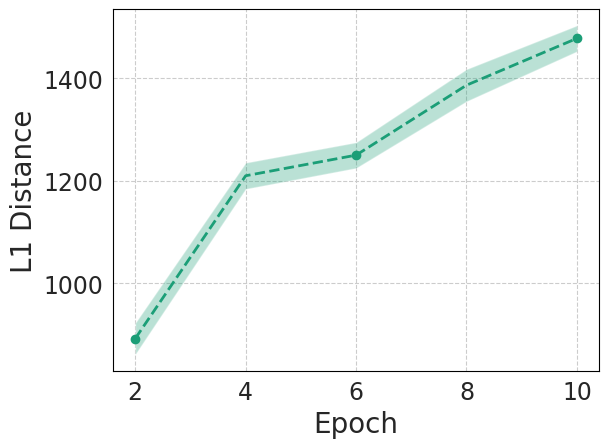

In [49]:
draw_graph(x_val=[2,4,6,8,10], y_vals=[l1_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='L1 Distance',
          std_vals=[l1_stdev_vals], markevery=2)

In [50]:
l2_mean_vals = [statistics.mean(i) for i in [l2_1,l2_3,l2_5,l2_7,l2_9]]
l2_stdev_vals = [statistics.stdev(i) for i in [l2_1,l2_3,l2_5,l2_7,l2_9]]

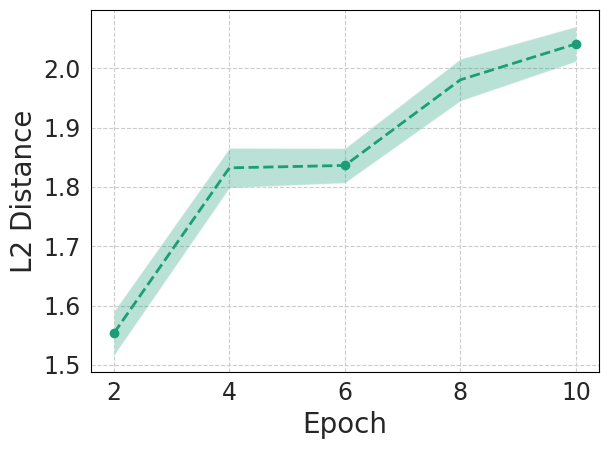

In [51]:
draw_graph(x_val=[2,4,6,8,10], y_vals=[l2_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='L2 Distance',
          std_vals=[l2_stdev_vals], markevery=2)

### cosine similarity

In [52]:
def calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader):
  loss, acc, real1, pred1 = eval(mdl1,testloader)
  loss, acc, real2, pred2 = eval(mdl2,testloader)
  pred1=np.array(pred1)
  pred2=np.array(pred2)
  MAE = np.mean(np.abs(pred1 - pred2))
  MSE = np.mean((pred1 - pred2)**2)

  vector1 = np.array(pred1, dtype=np.float64)
  vector2 = np.array(pred2, dtype=np.float64)

  # Calculate cosine similarity
  cos_sims = cosine_similarity(vector1, vector2)

  avg_cos_sim = np.mean(cos_sims)
  return MAE, MSE, avg_cos_sim

In [53]:
def get_client_updates_cos_sim(ref_cli, client_ids, client_updates_list, round_no, testloader):

  updates_list = client_updates_list[round_no]
  cos_sim_all = []
  MAE_all = []
  MSE_all = []
  print('Ref client ID: ', ref_cli)
  print('Round No.: ',round_no)
  ref_cli_mdl = updates_list[ref_cli][0]
  for cli in client_ids:
    print('comparing with client: ', cli)
    if ref_cli!=cli:
      other_mdl = updates_list[cli][0]

      mdl1 = get_mdl_from_weights(ref_cli_mdl)
      mdl2 = get_mdl_from_weights(other_mdl)

      MAE, MSE, avg_cos_sim = calc_MAE_MSE_cos_sim(mdl1,mdl2,testloader)
      print(avg_cos_sim)
      MAE_all.append(MAE)
      MSE_all.append(MSE)
      cos_sim_all.append(avg_cos_sim)
  return MAE_all, MSE_all, cos_sim_all

In [54]:
# client_updates_list[0]['1'][0]

In [55]:
testloader = get_testloader(len_test=1000) # for 1000 sample testdata
CLI_LIST=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
MAE_0, MSE_0, cos_sim_0 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=0, testloader=testloader)
MAE_1, MSE_1, cos_sim_1 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=1, testloader=testloader)
MAE_3, MSE_3, cos_sim_3 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=3, testloader=testloader)
MAE_4, MSE_4, cos_sim_4 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=4, testloader=testloader)
MAE_5, MSE_5, cos_sim_5 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=5, testloader=testloader)
MAE_7, MSE_7, cos_sim_7 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=7, testloader=testloader)
MAE_9, MSE_9, cos_sim_9 = get_client_updates_cos_sim(ref_cli='0', client_ids=CLI_LIST, client_updates_list=client_updates_list, round_no=9, testloader=testloader)

Ref client ID:  0
Round No.:  0
comparing with client:  0
comparing with client:  1
-0.4894392213472951
comparing with client:  2
-0.45971176713825224
comparing with client:  3
-0.5766504670287351
comparing with client:  4
-0.5367580211250718
comparing with client:  5
-0.25199258205234826
comparing with client:  6
-0.4541333768280905
comparing with client:  7
-0.4265539432899547
comparing with client:  8
-0.5006723963216029
comparing with client:  9
-0.48905535222158814
Ref client ID:  0
Round No.:  1
comparing with client:  0
comparing with client:  1
-0.7616431135749796
comparing with client:  2
-0.8160597856969442
comparing with client:  3
-0.7441681921109564
comparing with client:  4
-0.8107912924447604
comparing with client:  5
-0.9166515358169463
comparing with client:  6
-0.9290579233341774
comparing with client:  7
-0.9116278120136745
comparing with client:  8
-0.8737674844385974
comparing with client:  9
-0.9396374405122155
Ref client ID:  0
Round No.:  3
comparing with client

In [56]:
cos_sim_mean_vals = [statistics.mean(i) for i in [cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9]]
cos_sim_stdev_vals = [statistics.stdev(i) for i in [cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9]]

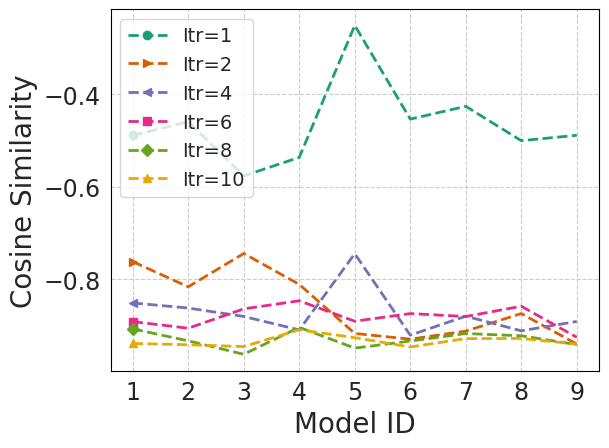

In [57]:
draw_graph(x_val=[i+1 for i in range(9)], y_vals=[cos_sim_0,cos_sim_1, cos_sim_3,cos_sim_5,cos_sim_7, cos_sim_9], markers=['o','>','<','s','D','^'],x_label='Model ID', y_label='Cosine Similarity',
           legend=['Itr=1','Itr=2','Itr=4','Itr=6','Itr=8','Itr=10'])

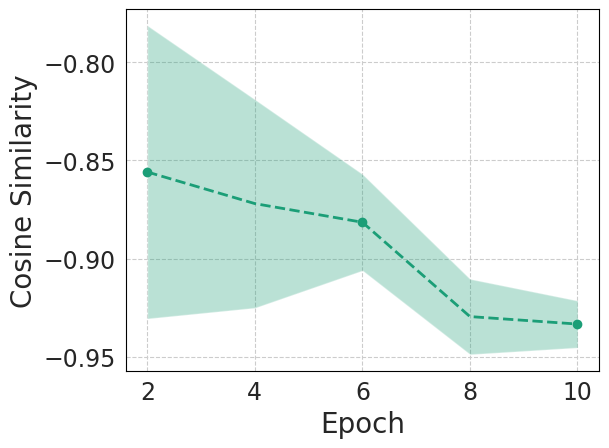

In [58]:
draw_graph(x_val=[2,4,6,8,10], y_vals=[cos_sim_mean_vals], markers=['o','>','<','s','D','^'],x_label='Epoch', y_label='Cosine Similarity',
          std_vals=[cos_sim_stdev_vals], markevery=2)